In [1]:
import pyexasol
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Establish connection to Exasol
C = pyexasol.connect(
    dsn='173.45.88.227..233:8563',
    user='app_ro',
    password='app_ro_12347',
    schema='prod_test'
)


In [2]:
# create the query above in Exasol

pub_id = input("Enter pub_id: ").strip()
adv_domain_id = input("Enter adv_domain_id: ").strip()
country_id = input("Enter country_id: ").strip()
start_date = input("Enter start_date: ").strip()
end_date = input("Enter end_date: ").strip()
target = input("Enter target: ").strip()

prod_sql = f"""
create or replace table prod_test.sababa_tool_production as
SELECT
    a.creation_date,
    a.pub_id,
    a.adv_domain_id,
    a.channel_id,
    a.country_id,
    e.name AS publisher,
    ea.name AS adv_domain,
    SUM(seen * b.est_daily_occ_impressions) AS impressions,
    0.001 * SUM(seen * b.est_daily_occ_impressions * ad_occurrence_cpm * used_for_spend) AS spend
FROM
    (
        SELECT
            creation_date,
            channel_id,
            country_id,
            pub_id,
            adv_id,
            is_panel,
            seen,
            ad_occurrence_id,
            ad_occurrence_cpm,
            used_for_spend,
            ticket_id,
            adv_domain_id
        FROM adc2_ops.thecube
        WHERE
            mg_position = 1
            AND used_for_imprs = 1
            AND used_for_spend = 1
            AND creation_date BETWEEN '{start_date}' AND '{end_date}'
            AND country_id = {country_id}
            AND adv_domain_id = {adv_domain_id}
            AND pub_id = {pub_id}
    ) a
JOIN adc2_dwh.pub_daily_impressions b
    ON a.creation_date = b.creation_date
    AND a.is_panel = b.is_panel
    AND a.pub_id = b.pub_id
    AND a.channel_id = b.channel_id
    AND a.country_id = b.country_id
JOIN adc2_ops.entities e ON e.id = a.pub_id
JOIN adc2_ops.entities ea ON ea.id = a.adv_domain_id
GROUP BY 1,2,3,4,5,6,7
"""

# Execute the insert
C.execute(prod_sql)

# Fetch the data back
prod_df = C.export_to_pandas("SELECT * FROM prod_test.sababa_tool_production")

# Print the DataFrame
print(prod_df)

   CREATION_DATE  PUB_ID  ADV_DOMAIN_ID  CHANNEL_ID  COUNTRY_ID  \
0     2025-05-22   39288       19420287           5           1   
1     2025-05-04   39288       19420287           5           1   
2     2025-05-20   39288       19420287           4           1   
3     2025-05-09   39288       19420287           4           1   
4     2025-05-18   39288       19420287           5           1   
5     2025-05-07   39288       19420287           4           1   
6     2025-05-12   39288       19420287           5           1   
7     2025-05-05   39288       19420287           5           1   
8     2025-05-08   39288       19420287           4           1   
9     2025-05-14   39288       19420287           4           1   
10    2025-05-17   39288       19420287           5           1   
11    2025-05-02   39288       19420287           4           1   
12    2025-05-18   39288       19420287           4           1   
13    2025-05-24   39288       19420287           5           

In [3]:
# Factors table

factor_df = f"""
create or replace table prod_test.sababa_tool_simulation_factor as
select 
a.*,
{target} / spend factor
from
(SELECT
    a.creation_date,
    a.channel_id,
    a.country_id,
    a.pub_id,
    a.adv_domain_id,
    a.is_panel,
    SUM(seen * b.est_daily_occ_impressions) AS impressions,
    0.001 * SUM(seen * b.est_daily_occ_impressions * ad_occurrence_cpm * used_for_spend) AS spend
FROM
    (
        SELECT
            creation_date,
            channel_id,
            country_id,
            pub_id,
            adv_id,
            is_panel,
            seen,
            ad_occurrence_id,
            ad_occurrence_cpm,
            used_for_spend,
            ticket_id,
            adv_domain_id
        FROM adc2_ops.thecube
        WHERE
            mg_position = 1
            AND used_for_imprs = 1
            AND used_for_spend = 1
            AND creation_date BETWEEN '{start_date}' AND '{end_date}'
            AND country_id = {country_id}
            AND adv_domain_id = {adv_domain_id}
            AND pub_id = {pub_id}
    ) a
JOIN adc2_dwh.pub_daily_impressions b
    ON a.creation_date = b.creation_date
    AND a.is_panel = b.is_panel
    AND a.pub_id = b.pub_id
    AND a.channel_id = b.channel_id
    AND a.country_id = b.country_id
JOIN adc2_ops.entities e ON e.id = a.pub_id
JOIN adc2_ops.entities ea ON ea.id = a.adv_domain_id
GROUP BY 1, 2, 3, 4, 5, 6) a
"""


# Execute the insert
C.execute(factor_df)

# Fetch the data back
factor_df = C.export_to_pandas("SELECT * FROM prod_test.sababa_tool_simulation_factor")

# Print the DataFrame
print(factor_df)

   CREATION_DATE  CHANNEL_ID  COUNTRY_ID  PUB_ID  ADV_DOMAIN_ID  IS_PANEL  \
0     2025-05-01           4           1   39288       19420287         0   
1     2025-05-02           4           1   39288       19420287         0   
2     2025-05-07           4           1   39288       19420287         0   
3     2025-05-04           4           1   39288       19420287         0   
4     2025-05-13           4           1   39288       19420287         0   
5     2025-05-14           4           1   39288       19420287         0   
6     2025-05-18           4           1   39288       19420287         0   
7     2025-05-16           4           1   39288       19420287         1   
8     2025-05-20           4           1   39288       19420287         0   
9     2025-05-09           4           1   39288       19420287         0   
10    2025-05-14           4           1   39288       19420287         1   
11    2025-05-10           4           1   39288       19420287         0   

In [ ]:
# simulation tables creation


# Create prod_test.sababa_tool_thecube
create_thecube = f"""
CREATE OR REPLACE TABLE prod_test.sababa_tool_thecube AS
SELECT
    a.creation_date,
    a.channel_id,
    a.country_id,
    a.pub_id,
    a.adv_id,
    a.is_panel,
    a.seen * 1000 * factor AS seen,
    a.ad_occurrence_id,
    a.ad_occurrence_cpm,
    a.used_for_spend,
    a.ticket_id,
    a.adv_domain_id
FROM adc2_ops.thecube a
LEFT JOIN prod_test.sababa_tool_simulation_factor f
    ON f.creation_date = a.creation_date
    AND f.channel_id = a.channel_id
    AND f.country_id = a.country_id 
    AND f.pub_id = a.pub_id
    AND f.adv_domain_id = a.adv_domain_id
    AND f.is_panel = a.is_panel
WHERE
    a.mg_position = 1
    AND a.used_for_imprs = 1
    AND a.used_for_spend = 1
    AND a.creation_date BETWEEN '{start_date}' AND '{end_date}'
    AND a.country_id = {country_id}
    AND a.pub_id = {pub_id}
    AND a.adv_domain_id = {adv_domain_id}
"""

# Create sababa_tool_impressions
create_impressions = f"""
CREATE OR REPLACE TABLE prod_test.sababa_tool_impressions AS
SELECT
    creation_date,
    channel_id,
    country_id,
    pub_id,
    is_panel,
    total_daily_occs * 1000 AS total_daily_occs,
    est_daily_occ_impressions / 1000 AS est_daily_occ_impressions
FROM adc2_dwh.pub_daily_impressions
WHERE
    creation_date BETWEEN '{start_date}' AND '{end_date}'
    AND country_id = {country_id}
    AND pub_id = {pub_id}
"""

# Create sababa_tool_simulation
create_simulation = """
CREATE OR REPLACE TABLE prod_test.sababa_tool_simulation AS
SELECT
    a.creation_date,
    a.pub_id,
    a.adv_domain_id,
    a.channel_id,
    a.country_id,
    e.name AS publisher,
    ea.name AS adv_domain,
    SUM(seen * est_daily_occ_impressions) AS impressions,
    0.001 * SUM(seen * est_daily_occ_impressions * ad_occurrence_cpm * used_for_spend) AS spend
FROM prod_test.sababa_tool_thecube a
JOIN sababa_tool_impressions b
    ON a.creation_date = b.creation_date
    AND a.is_panel = b.is_panel
    AND a.pub_id = b.pub_id
    AND a.channel_id = b.channel_id
    AND a.country_id = b.country_id
JOIN adc2_ops.entities e ON e.id = a.pub_id
JOIN adc2_ops.entities ea ON ea.id = a.adv_domain_id
GROUP BY 1,2,3,4,5,6,7
"""

# Execute each step separately
C.execute(create_thecube)
C.execute(create_impressions)
C.execute(create_simulation)

# Fetch result
tc_df = C.export_to_pandas("SELECT * FROM prod_test.sababa_tool_simulation")
print(tc_df)

   CREATION_DATE  PUB_ID  ADV_DOMAIN_ID  CHANNEL_ID  COUNTRY_ID  \
0     2025-05-01   39288       19420287           5           1   
1     2025-05-18   39288       19420287           4           1   
2     2025-05-04   39288       19420287           5           1   
3     2025-05-02   39288       19420287           4           1   
4     2025-05-19   39288       19420287           5           1   
5     2025-05-03   39288       19420287           5           1   
6     2025-05-24   39288       19420287           5           1   
7     2025-05-17   39288       19420287           4           1   
8     2025-05-07   39288       19420287           5           1   
9     2025-05-21   39288       19420287           4           1   
10    2025-05-22   39288       19420287           5           1   
11    2025-05-11   39288       19420287           5           1   
12    2025-05-14   39288       19420287           5           1   
13    2025-05-13   39288       19420287           4           

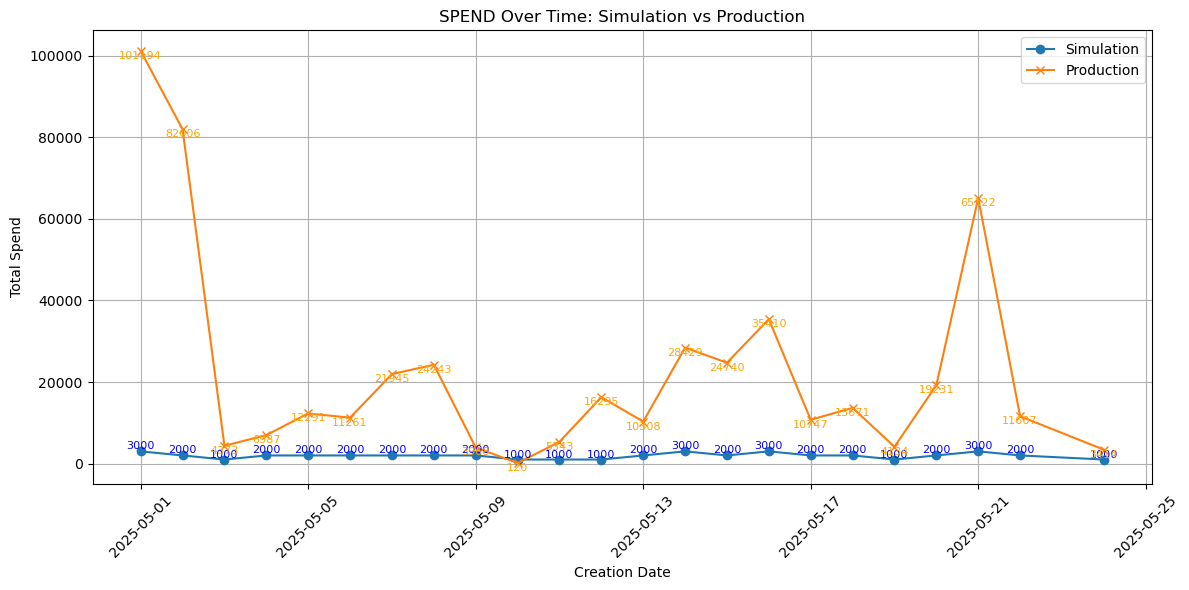

In [18]:
import matplotlib.pyplot as plt

# Query for simulation table
query_simulation = """
SELECT CREATION_DATE, SUM(SPEND) AS TOTAL_SPEND
FROM sababa_tool_simulation
GROUP BY CREATION_DATE
ORDER BY CREATION_DATE
"""
df_simulation = C.export_to_pandas(query_simulation)

# Query for production table
query_production = """
SELECT CREATION_DATE, SUM(SPEND) AS TOTAL_SPEND
FROM sababa_tool_production
GROUP BY CREATION_DATE
ORDER BY CREATION_DATE
"""
df_production = C.export_to_pandas(query_production)

# Convert CREATION_DATE to datetime
df_simulation['CREATION_DATE'] = pd.to_datetime(df_simulation['CREATION_DATE'])
df_production['CREATION_DATE'] = pd.to_datetime(df_production['CREATION_DATE'])

# Plotting
plt.figure(figsize=(12, 6))

# Plot Simulation line
plt.plot(df_simulation['CREATION_DATE'], df_simulation['TOTAL_SPEND'], label='Simulation', marker='o')
# Add text labels for Simulation
for x, y in zip(df_simulation['CREATION_DATE'], df_simulation['TOTAL_SPEND']):
    plt.text(x, y, f'{y:.0f}', ha='center', va='bottom', fontsize=8, color='blue')

# Plot Production line
plt.plot(df_production['CREATION_DATE'], df_production['TOTAL_SPEND'], label='Production', marker='x')
# Add text labels for Production
for x, y in zip(df_production['CREATION_DATE'], df_production['TOTAL_SPEND']):
    plt.text(x, y, f'{y:.0f}', ha='center', va='top', fontsize=8, color='orange')

# Final formatting
plt.title('SPEND Over Time: Simulation vs Production')
plt.xlabel('Creation Date')
plt.ylabel('Total Spend')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
import os

want_that = input("Do you want this simulation? Y/N: ").strip().upper()

if want_that == 'Y' or 'y' or 'yes' or 'YES' or 'Yes':
    # Merge the two DataFrames on CREATION_DATE
    df_combined = pd.merge(df_production, df_simulation, on='CREATION_DATE', how='outer', suffixes=('_PRODUCTION', '_SIMULATION'))

    # Sort by date
    df_combined = df_combined.sort_values(by='CREATION_DATE')

    # Rename columns for clarity
    df_combined.rename(columns={
        'TOTAL_SPEND_PRODUCTION': 'PRODUCTION_SPEND',
        'TOTAL_SPEND_SIMULATION': 'SIMULATION_SPEND'
    }, inplace=True)

    # Ask user for file save location
    ADDRESS = input("PLEASE WRITE THE CSV FILE LOCATION (with filename, e.g., C:/path/spend_comparison.csv): ").strip()

    # Ensure it ends with .csv
    if not ADDRESS.lower().endswith(".csv"):
        ADDRESS += ".csv"

    try:
        df_combined.to_csv(ADDRESS, index=False)
        print(f"✅ CSV file saved to: {ADDRESS}")
    except PermissionError:
        print(f"❌ Permission denied. Please check the folder access or close the file if it's open.")
    except Exception as e:
        print(f"❌ Failed to save CSV: {e}")
    print("Please use the following tables: prod_test.sababa_tool_thecube and prod_test.sababa_tool_impressions")
else:
    print("Try again with a different target.")

✅ CSV file saved to: C:\GIT_EINAR\AdvertiserSimulationTool\spend.csv
Please use the following tables: prod_test.sababa_tool_thecube and prod_test.sababa_tool_impressions
